# Grovers Search Algorithm

In [39]:
marked_states = ["0110", "1000"]

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import grover_operator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [41]:
# Find number of bits
num_qubits = max([len(i) for i in marked_states])

# Make all marked states have equal bit length
equal_marked_states = []
for state in marked_states:
    diff = num_qubits - len(state)
    equal_marked_states.append("0"*diff + state)

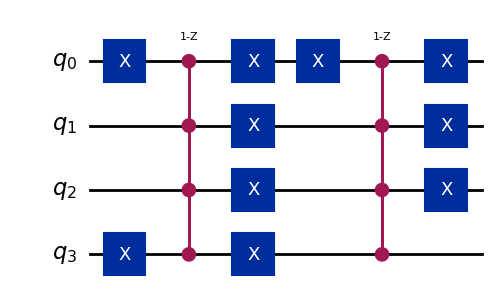

In [42]:
# Creating Oracle
# Key idea: Apply X to all target qubits which are 0. Apply MC Z with 1 target and num_qubits-1 control. Apply X to all target qubits which are 0.
# A pi phase will only be applied if all qubits are 1 after the first X-gates
oracle = QuantumCircuit(num_qubits)

for target in equal_marked_states:
    rev_target = target[::-1] # Qiskit works with qubits backward
    
    # Find 0 indices
    indices = [i for i, ch in enumerate(rev_target) if ch == "0"]
    
    # Create gates
    if indices:
        oracle.x(indices)
        oracle.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        oracle.x(indices)
    else:
        oracle.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)

# Return a drawing of the circuit using MatPlotLib ("mpl").
oracle.draw("mpl")

Full Circuit:


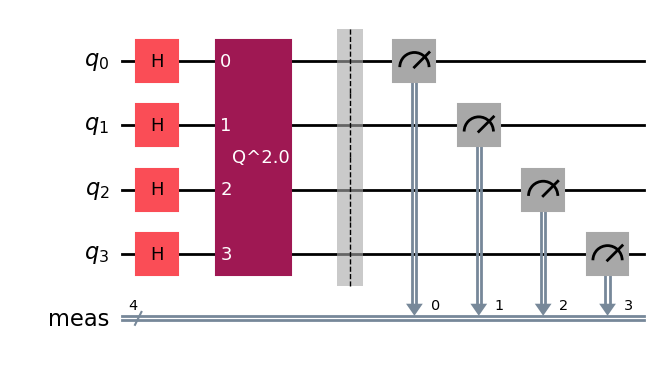

In [43]:
# Full Circuit
optimal_iterations = np.floor(np.pi / 4 * np.sqrt(2**num_qubits / len(marked_states))) # optimal number of itterations for maximum likelyhood

grover_op = grover_operator(oracle)

qc = QuantumCircuit(grover_op.num_qubits)

# Convert all qubits to |+>
qc.h(range(grover_op.num_qubits))

# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_iterations), inplace=True)

# Measure all qubits
qc.measure_all()

print("Full Circuit:")
qc.draw(output="mpl", style="iqp")

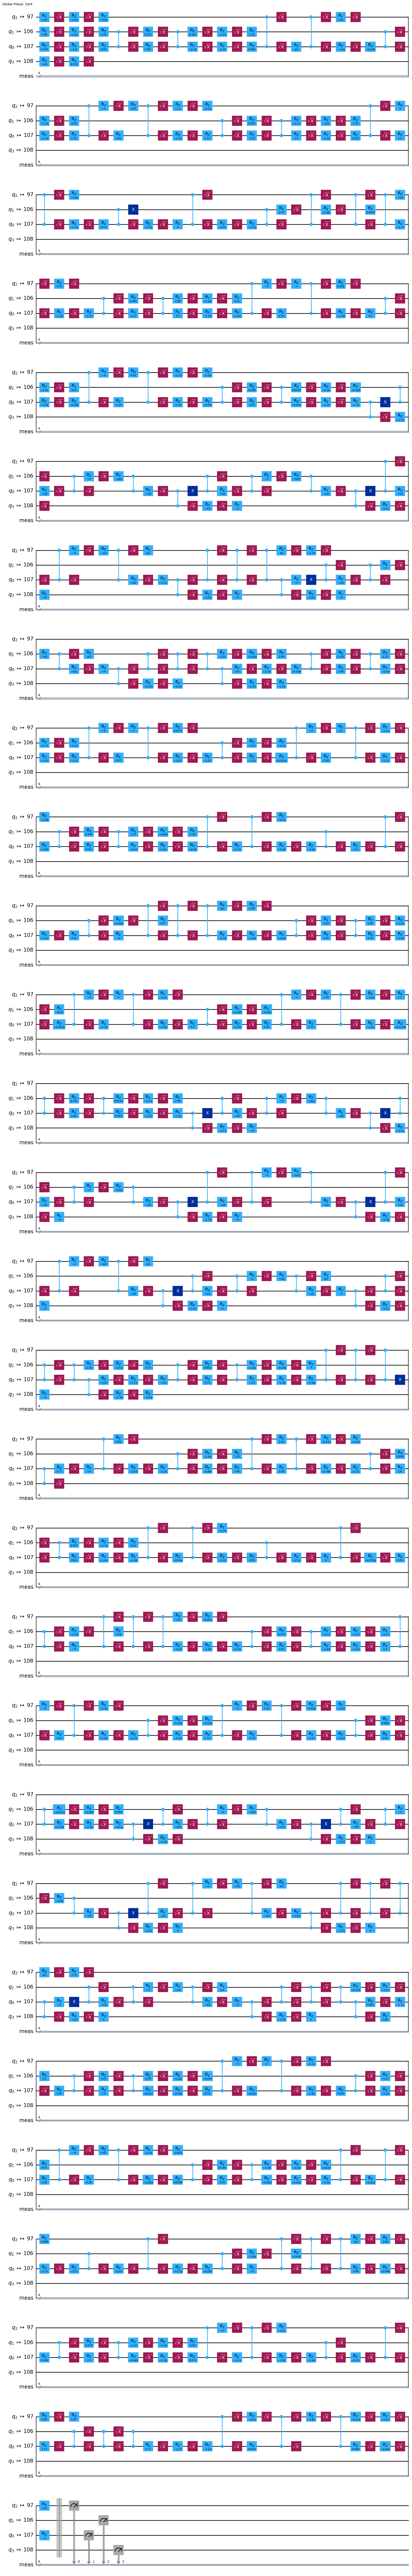

In [ ]:
# Set up compute instance
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
circuit_isa = pm.run(qc)
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [45]:
# Execute on Hardware
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
job = sampler.run([circuit_isa])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d4nh0f06ggmc738sap30
>>> Job Status: QUEUED


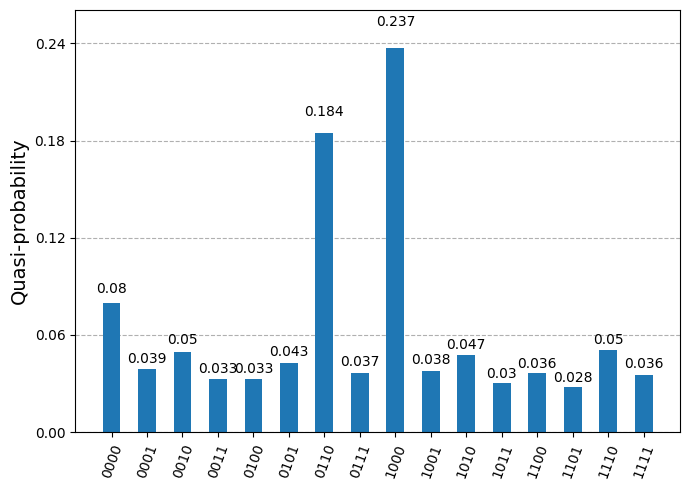

In [47]:
# Results
job_id = "d4nh0f06ggmc738sap30"

if service.job(job_id).status() == "DONE":
    output = service.job(job_id).result()
    dist = output[0].data.meas.get_counts()

# Plot dist
plot_distribution(dist)